In [ ]:
import os
import time

import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torchvision

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset = list (trainset)
for i in range (len (trainset)):
  if trainset [i][-1] in [2,3,4,5,6,7]:
    trainset [i] = (trainset[i][0], 0)
  else:
    trainset [i] = (trainset[i][0], 1)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# train, valid = random_split (trainset, [len (trainset)*0.8, len (trainset)*0.2])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testset = list (testset)
for i in range (len (testset)):
  if testset [i][-1] in [2,3,4,5,6,7]:
    testset [i] = (testset[i][0], 0)
  else:
    testset [i] = (testset[i][0], 1)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 103389944.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
input_dim=trainset[0][0].shape[0]*trainset[0][0].shape[1]*trainset[0][0].shape[2]

In [ ]:
all_train_labels = []
all_test_labels = []
all_val_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)



print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))




Training labels: tensor([0, 1])
Training label distribution: tensor([30000, 20000])

Test labels: tensor([0, 1])
Test label distribution: tensor([6000, 4000])


In [ ]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor

class MLP(nn.Module):
    def __init__ (self, input_size, hidden_size, output_size, dropout_prob):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.elu1 = nn.ELU()
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.elu2 = nn.ELU()
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.dropout1(self.elu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.elu2(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return F.sigmoid (x)

In [ ]:
class Gated_Network(nn.Module):
    def __init__(self, num_experts = 5, input_dim=1024):
        super(Gated_Network,self).__init__()
        self.gamma = nn.Parameter(torch.ones(1))
        self.s = nn.Parameter(torch.zeros(num_experts))

        self.mlp_expert1 = MLP(input_size=input_dim, hidden_size=800, output_size=1, dropout_prob = 0.5) 
        self.mlp_expert2 = MLP(input_size=input_dim, hidden_size=800, output_size=1, dropout_prob = 0.5) 
        self.mlp_expert3 = MLP(input_size=input_dim, hidden_size=800, output_size=1, dropout_prob = 0.5) 
        self.mlp_expert4 = MLP(input_size=input_dim, hidden_size=800, output_size=1, dropout_prob = 0.5) 
        self.mlp_expert5 = MLP(input_size=input_dim, hidden_size=800, output_size=1, dropout_prob = 0.5) 

        self.input_dim=input_dim

    def forward(self,input):
        mlp_out1 = self.mlp_expert1 (input.view(-1, self.input_dim))
        mlp_out2 = self.mlp_expert2 (input.view(-1, self.input_dim))
        mlp_out3 = self.mlp_expert3 (input.view(-1, self.input_dim))
        mlp_out4 = self.mlp_expert4 (input.view(-1, self.input_dim))
        mlp_out5 = self.mlp_expert5 (input.view(-1, self.input_dim))

        # print (mlp_out1)

        weights = F.softmax(self.s, dim=0).repeat(len(input),1,1).view(len(input),-1,1)
        
        stacked = torch.cat([mlp_out1.view(mlp_out1.shape[0],1,mlp_out1.shape[1]), mlp_out2.view(mlp_out2.shape[0],1,mlp_out2.shape[1]), mlp_out3.view(mlp_out3.shape[0],1,mlp_out3.shape[1]), mlp_out4.view(mlp_out4.shape[0],1,mlp_out4.shape[1]), mlp_out5.view(mlp_out5.shape[0],1,mlp_out5.shape[1])], dim=1)
        
        sum = torch.sum(stacked*weights,dim=1)
        wighted_sum=self.gamma*sum

        wighted_sum = wighted_sum.squeeze (-1)
        return wighted_sum

In [ ]:
def train_model(optimizer,trainloader,testloader,criterion,model,epochs):
    
    def train(optimizer,trainloader,criterion):
        model.train()
        train_loss=0
        y_true=[]
        y_pred=[]
        for images, labels in trainloader:
            model.zero_grad() 
            data = images.to(device)
            target = labels.float ().to(device)
            output = model(data)

            loss = criterion(output,target)

            threshold = torch.tensor([0.5])

            results = ((output.detach ().cpu ()>threshold).float()*1)
            
            train_loss+=loss.item()
            y_true+=list(target.detach().cpu().numpy())
            y_pred+=list(results.detach().cpu().numpy())
            loss.backward()
            optimizer.step()

            i=0
            epsilon = 5
            with torch.no_grad():
              for params in model.parameters():
                if i > 0:
                  newparams=params.detach().clone()
                  params.copy_(torch.where(newparams < 0, torch.exp(newparams - epsilon), newparams))
                i=i+1

        return train_loss/len(trainloader),accuracy_score(y_true,y_pred)

    def test(testloader,criterion):
        model.eval()
        y_true=[]
        y_pred=[]        
        val_loss = 0
        with torch.no_grad():
          for images, labels in testloader:
              data = images.to(device)
              target = labels.float ().to(device)
              output = model(data)

              threshold = torch.tensor([0.5])
              results = ((output.detach ().cpu ()>threshold).float()*1).detach ().cpu ()
              
              y_true+=list(target.detach().cpu().numpy())
              y_pred+=list(results.detach().cpu().numpy())
              val_loss += criterion(output, target).item()
        return val_loss/len(testloader),accuracy_score(y_true,y_pred)

        
    train_loss=[]
    test_loss=[]
    train_acc=[]
    test_acc=[]
    for epoch in tqdm(range(1, epochs + 1)):
        
        tr_loss,tr_acc=train(optimizer=optimizer,trainloader=trainloader,criterion=criterion)
        ts_loss,ts_acc=test(testloader,criterion=criterion)
        train_loss.append(tr_loss)
        test_loss.append(ts_loss)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
        print("train_acc",tr_acc)
        print("test_acc",ts_acc)
    return (train_loss,test_loss),(train_acc,test_acc)
    
def plot(Loss,EPOCH):
  x = list(range(1,EPOCH+1))
  fig, ax = plt.subplots(figsize=(7,7))
  ax.plot(x, Loss[0], '-', label='train', color='green')
  ax.plot(x, Loss[1], '-', label='test', color='red')
  ax.legend()
  plt.show()

In [ ]:
gated_network=Gated_Network(input_dim=input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH=50
criterion = nn.BCELoss()
model = gated_network.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam (model.parameters(), lr=0.001)
Loss, accuracy=train_model(optimizer,train_loader,test_loader,criterion,model,EPOCH)


  2%|▏         | 1/50 [00:10<08:26, 10.33s/it]

train_acc 0.67858
test_acc 0.7129


  4%|▍         | 2/50 [00:17<06:54,  8.64s/it]

train_acc 0.71254
test_acc 0.7247


  6%|▌         | 3/50 [00:24<06:06,  7.79s/it]

train_acc 0.72224
test_acc 0.7316


  8%|▊         | 4/50 [00:31<05:51,  7.65s/it]

train_acc 0.72834
test_acc 0.7357


 10%|█         | 5/50 [00:38<05:29,  7.32s/it]

train_acc 0.73144
test_acc 0.7388


 12%|█▏        | 6/50 [00:46<05:23,  7.35s/it]

train_acc 0.73246
test_acc 0.7383


 14%|█▍        | 7/50 [00:53<05:15,  7.34s/it]

train_acc 0.7353
test_acc 0.739


 16%|█▌        | 8/50 [01:00<05:02,  7.19s/it]

train_acc 0.73574
test_acc 0.739


 18%|█▊        | 9/50 [01:07<04:56,  7.23s/it]

train_acc 0.73866
test_acc 0.7405


 20%|██        | 10/50 [01:14<04:43,  7.08s/it]

train_acc 0.73876
test_acc 0.7401


 22%|██▏       | 11/50 [01:21<04:39,  7.18s/it]

train_acc 0.73848
test_acc 0.7415


 24%|██▍       | 12/50 [01:28<04:28,  7.08s/it]

train_acc 0.73896
test_acc 0.7425


 26%|██▌       | 13/50 [01:36<04:25,  7.19s/it]

train_acc 0.73928
test_acc 0.7418


 28%|██▊       | 14/50 [01:43<04:21,  7.25s/it]

train_acc 0.73996
test_acc 0.7408


 30%|███       | 15/50 [01:50<04:09,  7.12s/it]

train_acc 0.73968
test_acc 0.7425


 32%|███▏      | 16/50 [01:57<04:05,  7.23s/it]

train_acc 0.74116
test_acc 0.7434


 34%|███▍      | 17/50 [02:04<03:53,  7.09s/it]

train_acc 0.74152
test_acc 0.7437


 36%|███▌      | 18/50 [02:11<03:49,  7.18s/it]

train_acc 0.7412
test_acc 0.7428


 38%|███▊      | 19/50 [02:18<03:41,  7.13s/it]

train_acc 0.74162
test_acc 0.743


 40%|████      | 20/50 [02:26<03:34,  7.15s/it]

train_acc 0.74024
test_acc 0.7442


 42%|████▏     | 21/50 [02:33<03:29,  7.21s/it]

train_acc 0.74122
test_acc 0.7424


 44%|████▍     | 22/50 [02:40<03:18,  7.08s/it]

train_acc 0.74128
test_acc 0.7447


 46%|████▌     | 23/50 [02:47<03:13,  7.18s/it]

train_acc 0.74072
test_acc 0.7428


 48%|████▊     | 24/50 [02:54<03:03,  7.06s/it]

train_acc 0.74236
test_acc 0.7437


 50%|█████     | 25/50 [03:02<03:00,  7.20s/it]

train_acc 0.742
test_acc 0.744


 52%|█████▏    | 26/50 [03:09<02:52,  7.20s/it]

train_acc 0.74068
test_acc 0.7442


 54%|█████▍    | 27/50 [03:16<02:43,  7.13s/it]

train_acc 0.74056
test_acc 0.743


 56%|█████▌    | 28/50 [03:23<02:37,  7.17s/it]

train_acc 0.7422
test_acc 0.7438


 58%|█████▊    | 29/50 [03:30<02:27,  7.02s/it]

train_acc 0.74234
test_acc 0.7433


 60%|██████    | 30/50 [03:37<02:21,  7.07s/it]

train_acc 0.74218
test_acc 0.7435


 62%|██████▏   | 31/50 [03:43<02:11,  6.94s/it]

train_acc 0.74192
test_acc 0.7452


 64%|██████▍   | 32/50 [03:51<02:06,  7.03s/it]

train_acc 0.74206
test_acc 0.7441


 66%|██████▌   | 33/50 [04:00<02:12,  7.82s/it]

train_acc 0.74156
test_acc 0.7433


 68%|██████▊   | 34/50 [04:11<02:20,  8.81s/it]

train_acc 0.74364
test_acc 0.7438


 70%|███████   | 35/50 [04:18<02:03,  8.21s/it]

train_acc 0.74188
test_acc 0.7433


 72%|███████▏  | 36/50 [04:26<01:51,  7.98s/it]

train_acc 0.74332
test_acc 0.7449


 74%|███████▍  | 37/50 [04:33<01:39,  7.64s/it]

train_acc 0.74222
test_acc 0.745


 76%|███████▌  | 38/50 [04:40<01:30,  7.57s/it]

train_acc 0.74326
test_acc 0.7442


 78%|███████▊  | 39/50 [04:47<01:21,  7.37s/it]

train_acc 0.74338
test_acc 0.7458


 80%|████████  | 40/50 [04:54<01:13,  7.33s/it]

train_acc 0.74162
test_acc 0.7443


 82%|████████▏ | 41/50 [05:01<01:05,  7.33s/it]

train_acc 0.74336
test_acc 0.7455


 84%|████████▍ | 42/50 [05:08<00:57,  7.18s/it]

train_acc 0.74286
test_acc 0.746


 86%|████████▌ | 43/50 [05:16<00:50,  7.23s/it]

train_acc 0.7426
test_acc 0.7467


 88%|████████▊ | 44/50 [05:22<00:42,  7.09s/it]

train_acc 0.74222
test_acc 0.7457


 90%|█████████ | 45/50 [05:30<00:35,  7.17s/it]

train_acc 0.74232
test_acc 0.7459


 92%|█████████▏| 46/50 [05:37<00:28,  7.19s/it]

train_acc 0.74304
test_acc 0.7465


 94%|█████████▍| 47/50 [05:44<00:21,  7.15s/it]

train_acc 0.7431
test_acc 0.744


 96%|█████████▌| 48/50 [05:51<00:14,  7.18s/it]

train_acc 0.74416
test_acc 0.7445


 98%|█████████▊| 49/50 [05:58<00:07,  7.03s/it]

train_acc 0.74324
test_acc 0.7462


100%|██████████| 50/50 [06:05<00:00,  7.32s/it]

train_acc 0.74348
test_acc 0.746


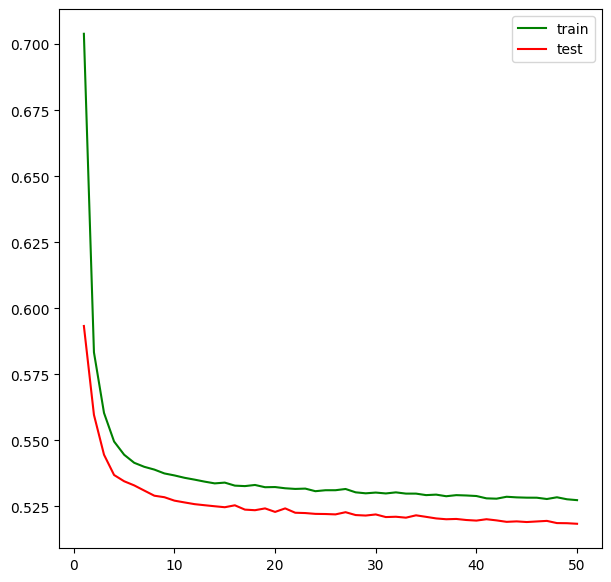

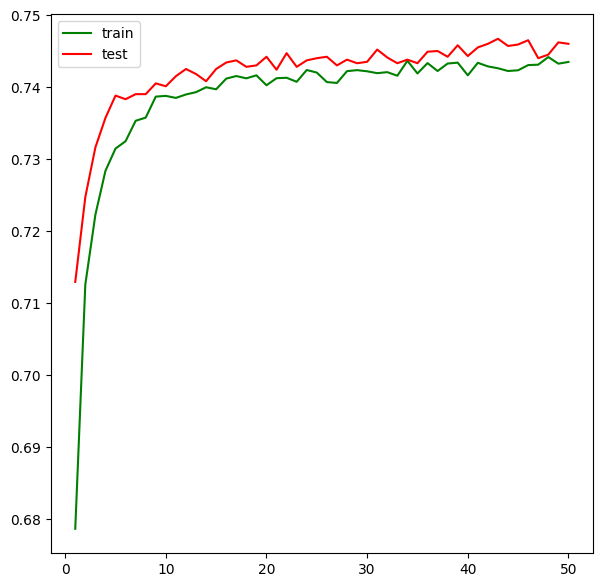

In [ ]:
plot(Loss,EPOCH)
plot(accuracy,EPOCH)

In [ ]:
torch.save(gated_network.state_dict(),"moe.pt")

In [ ]:
print (accuracy [0][-1] - accuracy [1][-1])

-0.0025199999999999667
